In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Part 1 : Finetune the Satmae (training_set dataset which consisit of 150 images).

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.3 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import rasterio
from transformers import AutoModel

In [4]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import rasterio
import numpy as np
import torch.nn as nn
from transformers import AutoConfig, AutoModel

# --------------------------
# Dataset: generate 4-band patches on-the-fly
# --------------------------
class TifTilesDataset(Dataset):
    def __init__(self, tif_dir, patch_size=224, stride=None, normalize=True):
        self.files = [os.path.join(tif_dir, f) for f in os.listdir(tif_dir) if f.endswith(".tif")]
        self.patch_size = patch_size
        self.stride = stride if stride else patch_size
        self.normalize = normalize
        self.samples = []

        for path in self.files:
            with rasterio.open(path) as src:
                _, H, W = src.read().shape
            for y in range(0, H - patch_size + 1, self.stride):
                for x in range(0, W - patch_size + 1, self.stride):
                    self.samples.append((path, x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, x, y = self.samples[idx]
        with rasterio.open(path) as src:
            img = src.read(window=((y, y+self.patch_size), (x, x+self.patch_size)))  # (C,H,W)

        img = torch.tensor(img, dtype=torch.float32)

        # normalize per band
        if self.normalize:
            img = (img - img.mean(dim=(1,2), keepdim=True)) / (img.std(dim=(1,2), keepdim=True) + 1e-6)

        return img  # [4, patch_size, patch_size]




In [5]:
# --------------------------
# Debug Step 1: Load dataset + one sample
# --------------------------
tif_dir = "/kaggle/input/satmae-finetune/tif_images"   # folder with your 150 unlabeled TIFFs
dataset = TifTilesDataset(tif_dir, patch_size=224, stride=224)

print("Total patches:", len(dataset))
print("Sample shape:", dataset[0].shape)  # expect [4,224,224]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Total patches: 9545
Sample shape: torch.Size([4, 224, 224])


### Load Satmae + Patch Input Conv

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CHECKPOINT = "MVRL/satmae-vitbase-multispec-pretrain"

# # Load config & override num_channels
# config = AutoConfig.from_pretrained(CHECKPOINT)
# config.num_channels = 4  # 👈 critical fix

# # Load pretrained backbone with updated config
# backbone = AutoModel.from_pretrained(CHECKPOINT, config=config, ignore_mismatched_sizes=True)

# # Fix projection layer to accept 4 channels
# old_proj = backbone.embeddings.patch_embeddings.projection
# new_proj = nn.Conv2d(
#     in_channels=4,
#     out_channels=old_proj.out_channels,
#     kernel_size=old_proj.kernel_size,
#     stride=old_proj.stride,
#     padding=old_proj.padding,
#     bias=old_proj.bias is not None
# )

# with torch.no_grad():
#     # copy pretrained RGB
#     new_proj.weight[:, :3, :, :] = old_proj.weight
#     # initialize NIR (4th band) as mean of RGB weights
#     new_proj.weight[:, 3:4, :, :] = old_proj.weight.mean(dim=1, keepdim=True)

# # replace and move to GPU
# backbone.embeddings.patch_embeddings.projection = new_proj.to(device)
# backbone.to(device)

# print("✅ SatMAE backbone now accepts 4 bands and moved to", device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT = "MVRL/satmae-vitbase-multispec-pretrain"

# load config and set num_channels=4
config = AutoConfig.from_pretrained(CHECKPOINT)
config.num_channels = 4

# load pretrained backbone
backbone = AutoModel.from_pretrained(CHECKPOINT, config=config)
backbone.to(device)

print("✅ SatMAE backbone already supports 4 bands")

# Debug forward pass
test_batch = torch.stack([dataset[0], dataset[1]]).to(device)  # [2,4,224,224]
print("Test batch shape:", test_batch.shape)

with torch.no_grad():
    out = backbone(pixel_values=test_batch)

print("Last hidden state shape:", out.last_hidden_state.shape)  # expect [2,196,hidden_dim]


config.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

2025-09-25 05:12:53.786665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758777174.119800      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758777174.216143      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at MVRL/satmae-vitbase-multispec-pretrain and are newly initialized: ['embeddings.cls_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'encoder.layer.0.layernorm_after.weight', 'encoder.layer.0.layernorm_before.bias', 'encoder.layer.0.layernorm_before.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.

✅ SatMAE backbone already supports 4 bands
Test batch shape: torch.Size([2, 4, 224, 224])


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Last hidden state shape: torch.Size([2, 785, 768])


## chunk 3 : patchify + reconstruction head

In [7]:
# 3. Reconstruction head (patch size = 8 for SatMAE)
# --------------------------
patch_size = 8  # SatMAE uses 8x8 patches
hidden_dim = backbone.config.hidden_size  # 768

decoder = nn.Linear(hidden_dim, patch_size * patch_size * 4).to(device)  # 8*8*4=256

optimizer = torch.optim.AdamW(
    list(backbone.parameters()) + list(decoder.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)
criterion = nn.MSELoss()

def patchify(imgs, patch_size=8):
    B, C, H, W = imgs.shape
    h = H // patch_size
    w = W // patch_size
    imgs = imgs.reshape(B, C, h, patch_size, w, patch_size)
    imgs = imgs.permute(0, 2, 4, 3, 5, 1)  # [B,h,w,p,p,C]
    patches = imgs.reshape(B, h*w, patch_size*patch_size*C)
    return patches


In [8]:
# Debug Step 3
# --------------------------
dummy = torch.randn(2, 4, 224, 224)
patches = patchify(dummy, patch_size=16)
print("Patchify output shape:", patches.shape)  # expect [2,196,1024] (196 patches, each 16*16*4=1024)


Patchify output shape: torch.Size([2, 196, 1024])


## chunk 4 : training loop

In [15]:
# --------------------------
# 4. Training Loop
# --------------------------
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

epochs = 4
mask_ratio = 0.75

for epoch in range(epochs):
    for imgs in dataloader:
        imgs = imgs.to(device)  # [B,4,224,224]

        outputs = backbone(pixel_values=imgs)
        hidden = outputs.last_hidden_state  # [B, 785, 768]

        # remove CLS token
        hidden_patches = hidden[:, 1:, :]  # [B,784,768]

        preds = decoder(hidden_patches)  # [B,784,256]
        target = patchify(imgs, patch_size=8)  # [B,784,256]

        # random mask
        B, N, D = target.shape
        mask = torch.rand(B, N, device=device) < mask_ratio

        # compute loss only on masked patches
        loss = criterion(preds[mask], target[mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss={loss.item():.4f}")


Epoch 1/4, Loss=0.0037
Epoch 2/4, Loss=0.0045
Epoch 3/4, Loss=0.0017
Epoch 4/4, Loss=0.0009


In [17]:
backbone.save_pretrained("./satmae-4band-feature-extractor")
print("✅ Saved fine-tuned 4-band SatMAE")


✅ Saved fine-tuned 4-band SatMAE


# debug before training

In [12]:
# check tensor shapes
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
mask_ratio = 0.75
imgs = next(iter(dataloader)).to(device)
with torch.no_grad():
    outputs = backbone(pixel_values=imgs)
    hidden = outputs.last_hidden_state
    hidden_patches = hidden[:, 1:, :]
    preds = decoder(hidden_patches)
    target = patchify(imgs, patch_size=8)

B, N, D = target.shape
mask = torch.rand(B, N, device=device) < mask_ratio

# Now run Steps 1–3 here before training

print("hidden shape:", hidden.shape)      # expect [B, 785, 768]  (CLS + 784 patches)
print("hidden_patches shape:", hidden_patches.shape)  # expect [B, 784, 768]
print("preds shape:", preds.shape)        # expect [B, 784, 256]
print("target shape:", target.shape)      # expect [B, 784, 256]
print("mask shape:", mask.shape)          # expect [B, 784]


hidden shape: torch.Size([4, 785, 768])
hidden_patches shape: torch.Size([4, 784, 768])
preds shape: torch.Size([4, 784, 256])
target shape: torch.Size([4, 784, 256])
mask shape: torch.Size([4, 784])


In [13]:
print("mask ratio set:", mask_ratio)
print("actual masked fraction:", mask.float().mean().item())


mask ratio set: 0.75
actual masked fraction: 0.75


In [14]:
# inspect masked selection

masked_preds = preds[mask]
masked_target = target[mask]

print("masked_preds shape:", masked_preds.shape)
print("masked_target shape:", masked_target.shape)


masked_preds shape: torch.Size([2352, 256])
masked_target shape: torch.Size([2352, 256])


In [18]:
from transformers import AutoModel

# reload your fine-tuned model
backbone = AutoModel.from_pretrained("./satmae-4band-feature-extractor").to(device)

# take a patch
sample = dataset[0].unsqueeze(0).to(device)  # [1,4,224,224]
with torch.no_grad():
    out = backbone(pixel_values=sample)
    embedding = out.last_hidden_state  # [1,785,768]
print("Embedding shape:", embedding.shape)


Embedding shape: torch.Size([1, 785, 768])


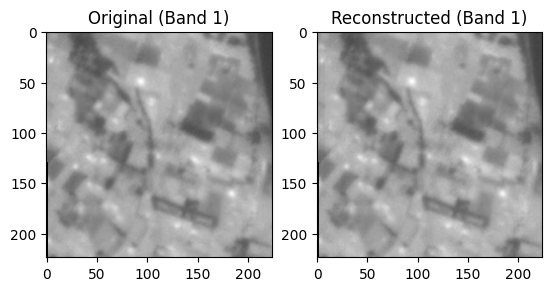

In [19]:
import matplotlib.pyplot as plt

# get one image
img = dataset[0].unsqueeze(0).to(device)  # [1,4,224,224]

with torch.no_grad():
    hidden = backbone(pixel_values=img).last_hidden_state[:, 1:, :]  # remove CLS
    preds = decoder(hidden)  # [1,784,256]
    recon = preds.reshape(1, 28, 28, 8, 8, 4).permute(0, 5, 1, 3, 2, 4)
    recon = recon.reshape(1, 4, 224, 224)

# take first band for visualization
orig = img[0, 0].cpu().numpy()
recn = recon[0, 0].cpu().numpy()

plt.subplot(1,2,1)
plt.title("Original (Band 1)")
plt.imshow(orig, cmap="gray")
plt.subplot(1,2,2)
plt.title("Reconstructed (Band 1)")
plt.imshow(recn, cmap="gray")
plt.show()


In [23]:
import torch
import rasterio
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# 1. Reload fine-tuned SatMAE
# --------------------------
backbone = AutoModel.from_pretrained("./satmae-4band-feature-extractor").to(device)
backbone.eval()

# --------------------------
# 2. Load one TIFF image (4-band, 224x224 crop)
# --------------------------
tif_path = "/kaggle/input/satmae-finetune/tif_images/GC01PS03D0001.tif"   # change to one of your TIFFs
with rasterio.open(tif_path) as src:
    img = src.read(window=((0,224),(0,224)))  # (C,H,W) -> 4x224x224

# convert to tensor
img = torch.tensor(img, dtype=torch.float32)

# normalize (same as training)
img = (img - img.mean(dim=(1,2), keepdim=True)) / (img.std(dim=(1,2), keepdim=True) + 1e-6)

# add batch dimension
img = img.unsqueeze(0).to(device)  # [1,4,224,224]

# --------------------------
# 3. Get embeddings
# --------------------------
with torch.no_grad():
    outputs = backbone(pixel_values=img)
    embeddings = outputs.last_hidden_state  # [1,785,768]

# remove CLS token, keep only patch embeddings
patch_embeddings = embeddings[:,1:,:].squeeze(0)  # [784,768]

print("Patch embeddings shape:", patch_embeddings.shape)  # [784,768]

# --------------------------
# 4. Print first 10 patch embeddings
# --------------------------
for i in range(10):
    print(f"Patch {i}: {patch_embeddings[i].tolist()}")
    print("-----------------------------------------------------------------------------------------------------------")


Patch embeddings shape: torch.Size([784, 768])
Patch 0: [-0.5173611044883728, 0.01339482981711626, -0.28952962160110474, -0.2868071496486664, 0.05699168145656586, 0.19823259115219116, 0.45237141847610474, -0.9452279210090637, -0.29419559240341187, 0.8113036155700684, -0.09999658912420273, -0.05266498029232025, 0.2665834426879883, 0.1571803241968155, -0.266345351934433, -0.11979470402002335, -0.8929093480110168, 0.10577410459518433, -0.04155334457755089, -1.4128714799880981, -0.3721613883972168, 0.01495475322008133, -0.846910834312439, -0.8607622981071472, 0.08898899704217911, -0.6566085815429688, 0.18258129060268402, 0.21359774470329285, 0.039153002202510834, 0.2863194942474365, -0.5712915658950806, -0.36976808309555054, -0.5075913071632385, 0.09169179946184158, -0.7883719205856323, -0.08935361355543137, 0.22919008135795593, 0.11634835600852966, 0.4309540092945099, 0.04068842530250549, 0.13527452945709229, 0.5090377926826477, -0.06930100917816162, -0.4901712238788605, 0.124515287578105